<a href="https://colab.research.google.com/github/tinayiluo0322/ECE_Final_Project_2025/blob/main/Targeted_Adversarial_Patch_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Patch Attack

## Load Data from CIFAR

In [7]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [8]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
print('==> Preparing data..')
#Image augmentation is used to train the model
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#Only the data is normalaized we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_train)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_test)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

==> Preparing data..


## Load Pretrained Model

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18  # Assuming you're using a standard architecture


In [10]:

# Step 1: Re-declare BasicBlock and ResNet
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes , planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

In [11]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [12]:
# Step 2: Instantiate the model
model = ResNet(BasicBlock, [2, 2, 2, 2])

# Use DataParallel
if train_on_gpu:
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

# Step 3: Load the pretrained weights
# (make sure ResNet18.pt is in your working directory or give full path)
pretrained_path = "ResNet18_20250419.pt"
model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

# Step 4: Move model to device and eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

print("Pretrained ResNet18 loaded and ready!")

Pretrained ResNet18 loaded and ready!


## Adversarial Patch Training

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve

In [14]:
# Function to create a random patch
def create_patch(patch_size=(3, 3)):
    patch = torch.randn(3, *patch_size, requires_grad=True, device=device)
    return patch

# # Function to apply the patch to images
# def place_patch(img, patch):
#     batch_size, _, h, w = img.size()
#     ph, pw = patch.size(1), patch.size(2)
#     for i in range(batch_size):
#         x_offset = torch.randint(0, h - ph + 1, (1,)).item()
#         y_offset = torch.randint(0, w - pw + 1, (1,)).item()
#         img[i, :, x_offset:x_offset+ph, y_offset:y_offset+pw] = patch
#     return img

# Function to apply the patch at the center of images
def place_patch(img, patch):
    batch_size, _, h, w = img.size()
    ph, pw = patch.size(1), patch.size(2)
    for i in range(batch_size):
        # Compute center coordinates
        x_center = h // 2
        y_center = w // 2
        # Compute top-left corner to place the patch
        x_offset = x_center - ph // 2
        y_offset = y_center - pw // 2
        # Place the patch at the center
        img[i, :, x_offset:x_offset+ph, y_offset:y_offset+pw] = patch
    return img

# Training function for adversarial patch
def patch_training_step(model, patch, target_class=None, dataloader=None, optimizer=None, criterion=None):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        optimizer.zero_grad()
        patched_images = place_patch(images, patch)
        outputs = model(patched_images)
        if target_class is not None:
            labels = torch.full((images.size(0),), target_class, dtype=torch.long, device=device)
        else:
            labels = torch.randint(0, 10, (images.size(0),), device=device)  # Random class for untargeted attack
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

# Function to train the adversarial patch
def train_adversarial_patch(model, patch, target_class=None, num_epochs=10):
    patch_optimizer = optim.Adam([patch], lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        loss = patch_training_step(model, patch, target_class, train_loader, patch_optimizer, criterion)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

# Function to evaluate the success rate of the adversarial patch
def evaluate_patch(model, patch, dataloader, target_class=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images, patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)
            if target_class is not None:
                correct += (predicted == target_class).sum().item()
            else:
                correct += (predicted != labels).sum().item()  # Evaluate untargeted attack
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Attack Success Rate: {accuracy:.2f}%")



# Function to visualize the patch
def visualize_patch(patch):
    patch = patch.detach().cpu().numpy()
    patch = np.clip((patch - patch.min()) / (patch.max() - patch.min()), 0, 1)

    plt.figure(figsize=(2, 2))
    plt.imshow(np.transpose(patch, (1, 2, 0)))  # [C, H, W] -> [H, W, C]
    plt.title("Adversarial Patch")
    plt.axis('off')
    plt.show()

# Function to visualize misclassified patched images
def visualize_misclassified_patched_images(model, patch, dataloader, classes, target_class, num_examples=5):
    model.eval()
    examples_shown = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        patched_images = place_patch(images.clone(), patch)
        with torch.no_grad():
            original_preds = model(images).argmax(dim=1)
            patched_preds = model(patched_images).argmax(dim=1)
        for i in range(images.size(0)):
            if patched_preds[i] == target_class:  # Targeted attack
                original_image = (images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5
                patched_image = (patched_images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5

                fig, axes = plt.subplots(1, 2, figsize=(4, 4))
                axes[0].imshow(np.clip(original_image, 0, 1))
                axes[0].set_title(f"Original Image\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[original_preds[i].item()]}")

                axes[1].imshow(np.clip(patched_image, 0, 1))
                axes[1].set_title(f"Image with Adversarial Patch\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[patched_preds[i].item()]}")

                plt.show()
                examples_shown += 1
                if examples_shown >= num_examples:
                    return


Training for patch size: (3, 3) with target class: airplane
Epoch 1/20, Loss: 8.4094
Epoch 2/20, Loss: 5.3503
Epoch 3/20, Loss: 4.0362
Epoch 4/20, Loss: 3.4708
Epoch 5/20, Loss: 3.1882
Epoch 6/20, Loss: 3.0402
Epoch 7/20, Loss: 2.9396
Epoch 8/20, Loss: 2.8642
Epoch 9/20, Loss: 2.8006
Epoch 10/20, Loss: 2.7559
Epoch 11/20, Loss: 2.7087
Epoch 12/20, Loss: 2.6791
Epoch 13/20, Loss: 2.6466
Epoch 14/20, Loss: 2.6231
Epoch 15/20, Loss: 2.6116
Epoch 16/20, Loss: 2.6023
Epoch 17/20, Loss: 2.5939
Epoch 18/20, Loss: 2.5867
Epoch 19/20, Loss: 2.5808
Epoch 20/20, Loss: 2.5754
Visualizing patch of size (3, 3) for target class airplane


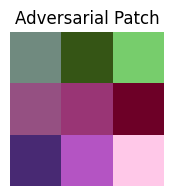

Attack Success Rate: 0.00%

Training for patch size: (5, 5) with target class: airplane
Epoch 1/20, Loss: 7.6762
Epoch 2/20, Loss: 4.5993
Epoch 3/20, Loss: 3.6782
Epoch 4/20, Loss: 3.0068
Epoch 5/20, Loss: 2.5848
Epoch 6/20, Loss: 2.4120
Epoch 7/20, Loss: 2.3162
Epoch 8/20, Loss: 2.2378
Epoch 9/20, Loss: 2.1824
Epoch 10/20, Loss: 2.1487
Epoch 11/20, Loss: 2.1207
Epoch 12/20, Loss: 2.0963
Epoch 13/20, Loss: 2.0733
Epoch 14/20, Loss: 2.0517
Epoch 15/20, Loss: 2.0273
Epoch 16/20, Loss: 2.0113
Epoch 17/20, Loss: 2.0009
Epoch 18/20, Loss: 1.9928
Epoch 19/20, Loss: 1.9870
Epoch 20/20, Loss: 1.9823
Visualizing patch of size (5, 5) for target class airplane


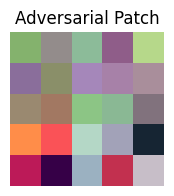

Attack Success Rate: 0.06%


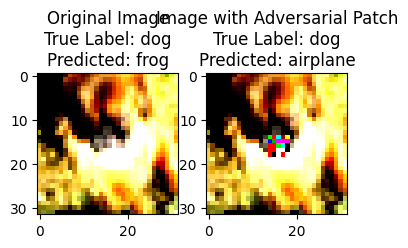

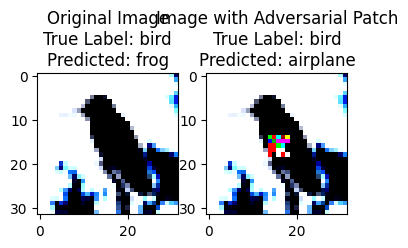

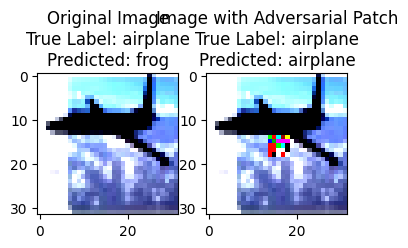

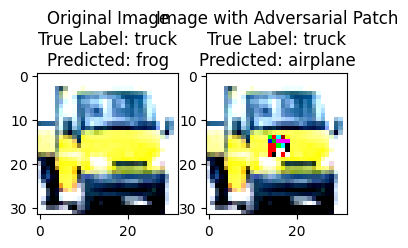

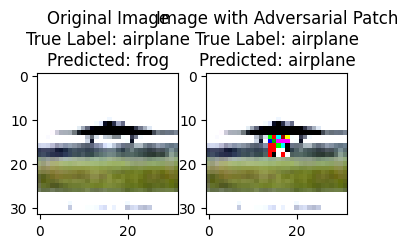


Training for patch size: (7, 7) with target class: airplane
Epoch 1/20, Loss: 6.5983
Epoch 2/20, Loss: 3.4620
Epoch 3/20, Loss: 2.4271
Epoch 4/20, Loss: 1.9440
Epoch 5/20, Loss: 1.5603
Epoch 6/20, Loss: 1.2581
Epoch 7/20, Loss: 1.0684
Epoch 8/20, Loss: 0.9271
Epoch 9/20, Loss: 0.8115
Epoch 10/20, Loss: 0.7262
Epoch 11/20, Loss: 0.6658
Epoch 12/20, Loss: 0.6162
Epoch 13/20, Loss: 0.5704
Epoch 14/20, Loss: 0.5343
Epoch 15/20, Loss: 0.5107
Epoch 16/20, Loss: 0.4912
Epoch 17/20, Loss: 0.4721
Epoch 18/20, Loss: 0.4517
Epoch 19/20, Loss: 0.4297
Epoch 20/20, Loss: 0.4034
Visualizing patch of size (7, 7) for target class airplane


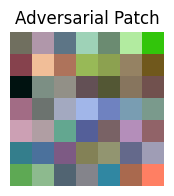

Attack Success Rate: 98.80%


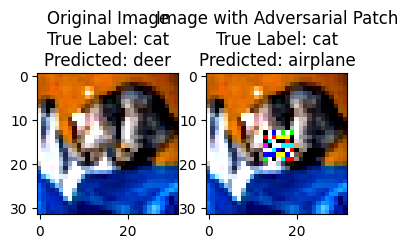

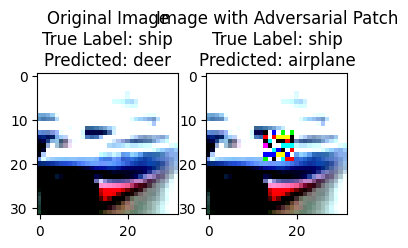

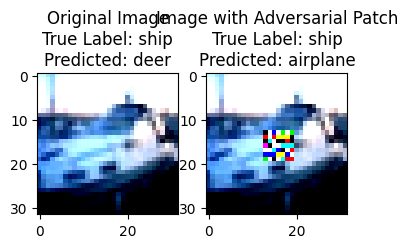

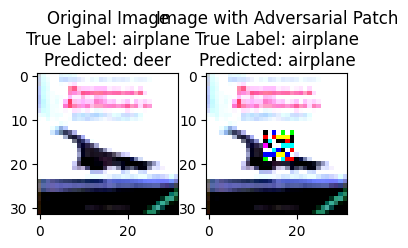

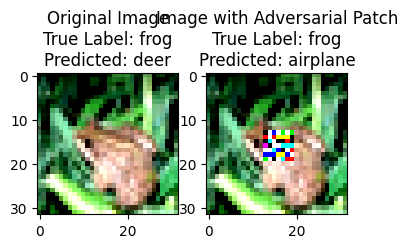


Training for patch size: (16, 16) with target class: airplane
Epoch 1/20, Loss: 2.0351
Epoch 2/20, Loss: 0.7417
Epoch 3/20, Loss: 0.3042
Epoch 4/20, Loss: 0.1463
Epoch 5/20, Loss: 0.0811
Epoch 6/20, Loss: 0.0497
Epoch 7/20, Loss: 0.0340
Epoch 8/20, Loss: 0.0253
Epoch 9/20, Loss: 0.0197
Epoch 10/20, Loss: 0.0160
Epoch 11/20, Loss: 0.0136
Epoch 12/20, Loss: 0.0117
Epoch 13/20, Loss: 0.0101
Epoch 14/20, Loss: 0.0088
Epoch 15/20, Loss: 0.0078
Epoch 16/20, Loss: 0.0069
Epoch 17/20, Loss: 0.0061
Epoch 18/20, Loss: 0.0055
Epoch 19/20, Loss: 0.0050
Epoch 20/20, Loss: 0.0045
Visualizing patch of size (16, 16) for target class airplane


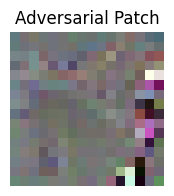

Attack Success Rate: 100.00%


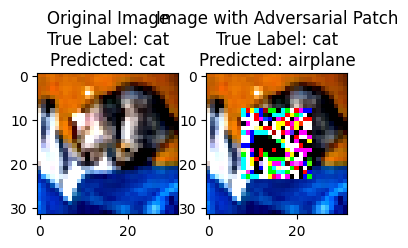

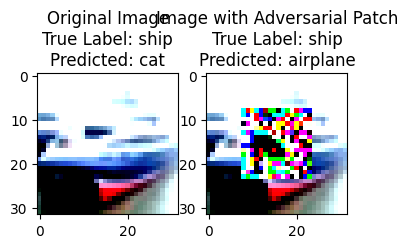

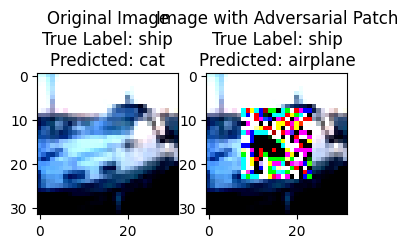

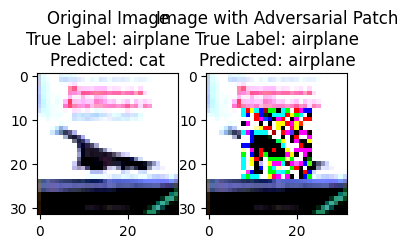

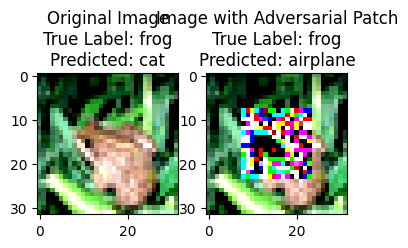


Training for patch size: (3, 3) with target class: automobile
Epoch 1/20, Loss: 8.3853
Epoch 2/20, Loss: 5.1030
Epoch 3/20, Loss: 3.3999
Epoch 4/20, Loss: 2.8721
Epoch 5/20, Loss: 2.6757
Epoch 6/20, Loss: 2.5205
Epoch 7/20, Loss: 2.3749
Epoch 8/20, Loss: 2.2642
Epoch 9/20, Loss: 2.1656
Epoch 10/20, Loss: 2.0908
Epoch 11/20, Loss: 2.0455
Epoch 12/20, Loss: 2.0184
Epoch 13/20, Loss: 1.9959
Epoch 14/20, Loss: 1.9608
Epoch 15/20, Loss: 1.9425
Epoch 16/20, Loss: 1.9308
Epoch 17/20, Loss: 1.9214
Epoch 18/20, Loss: 1.9144
Epoch 19/20, Loss: 1.9082
Epoch 20/20, Loss: 1.9035
Visualizing patch of size (3, 3) for target class automobile


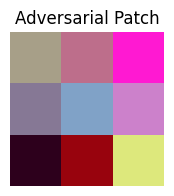

Attack Success Rate: 0.26%


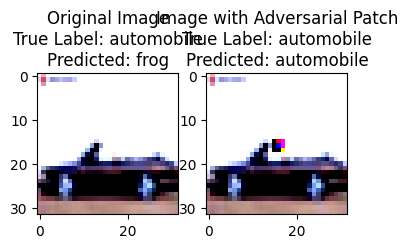

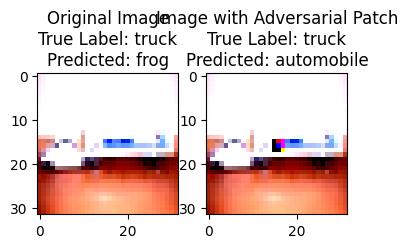

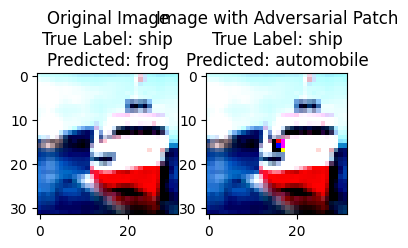

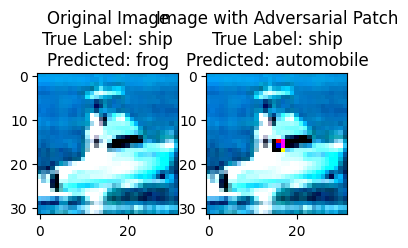

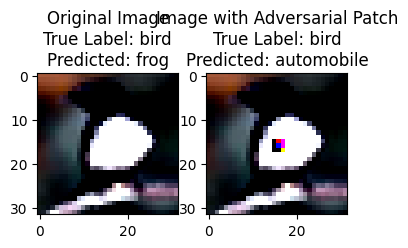


Training for patch size: (5, 5) with target class: automobile
Epoch 1/20, Loss: 7.1940
Epoch 2/20, Loss: 3.8189
Epoch 3/20, Loss: 2.7431
Epoch 4/20, Loss: 2.3262
Epoch 5/20, Loss: 2.1328
Epoch 6/20, Loss: 1.9288
Epoch 7/20, Loss: 1.7466
Epoch 8/20, Loss: 1.6614
Epoch 9/20, Loss: 1.6095
Epoch 10/20, Loss: 1.5640
Epoch 11/20, Loss: 1.5321
Epoch 12/20, Loss: 1.5093
Epoch 13/20, Loss: 1.4877
Epoch 14/20, Loss: 1.4685
Epoch 15/20, Loss: 1.4483
Epoch 16/20, Loss: 1.4254
Epoch 17/20, Loss: 1.4108
Epoch 18/20, Loss: 1.3989
Epoch 19/20, Loss: 1.3881
Epoch 20/20, Loss: 1.3731
Visualizing patch of size (5, 5) for target class automobile


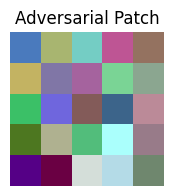

Attack Success Rate: 35.67%


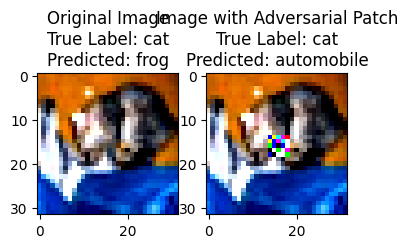

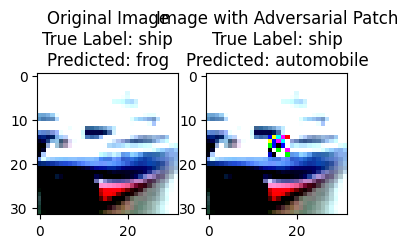

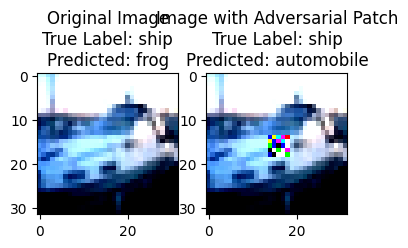

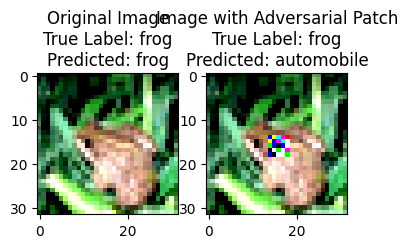

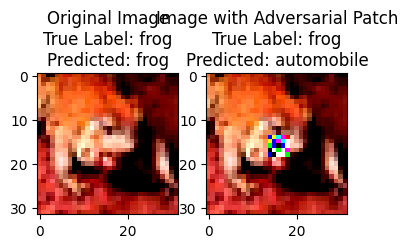


Training for patch size: (7, 7) with target class: automobile
Epoch 1/20, Loss: 6.2787
Epoch 2/20, Loss: 2.7063
Epoch 3/20, Loss: 1.2249
Epoch 4/20, Loss: 0.7801
Epoch 5/20, Loss: 0.5415
Epoch 6/20, Loss: 0.4217
Epoch 7/20, Loss: 0.3472
Epoch 8/20, Loss: 0.2904
Epoch 9/20, Loss: 0.2461
Epoch 10/20, Loss: 0.1995
Epoch 11/20, Loss: 0.1717
Epoch 12/20, Loss: 0.1527
Epoch 13/20, Loss: 0.1374
Epoch 14/20, Loss: 0.1270
Epoch 15/20, Loss: 0.1193
Epoch 16/20, Loss: 0.1137
Epoch 17/20, Loss: 0.1097
Epoch 18/20, Loss: 0.1059
Epoch 19/20, Loss: 0.1027
Epoch 20/20, Loss: 0.1001
Visualizing patch of size (7, 7) for target class automobile


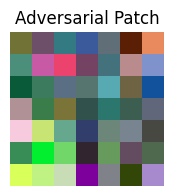

Attack Success Rate: 99.99%


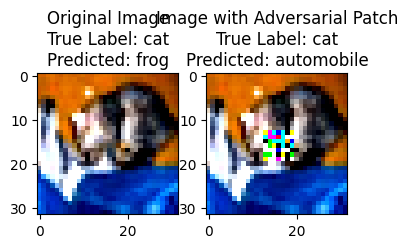

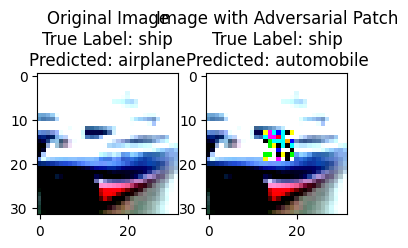

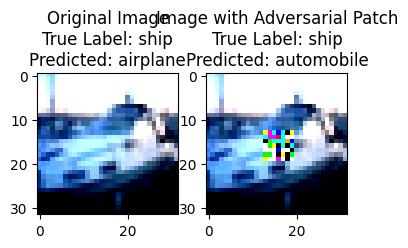

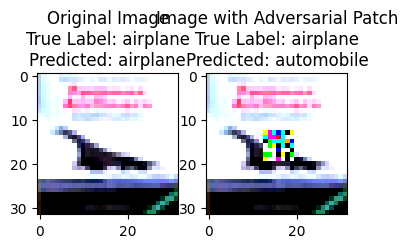

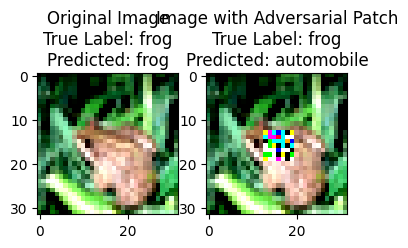


Training for patch size: (16, 16) with target class: automobile
Epoch 1/20, Loss: 0.8485
Epoch 2/20, Loss: 0.2338
Epoch 3/20, Loss: 0.1142
Epoch 4/20, Loss: 0.0642
Epoch 5/20, Loss: 0.0407
Epoch 6/20, Loss: 0.0277
Epoch 7/20, Loss: 0.0200
Epoch 8/20, Loss: 0.0148
Epoch 9/20, Loss: 0.0114
Epoch 10/20, Loss: 0.0093
Epoch 11/20, Loss: 0.0078
Epoch 12/20, Loss: 0.0068
Epoch 13/20, Loss: 0.0059
Epoch 14/20, Loss: 0.0053
Epoch 15/20, Loss: 0.0048
Epoch 16/20, Loss: 0.0045
Epoch 17/20, Loss: 0.0042
Epoch 18/20, Loss: 0.0039
Epoch 19/20, Loss: 0.0037
Epoch 20/20, Loss: 0.0036
Visualizing patch of size (16, 16) for target class automobile


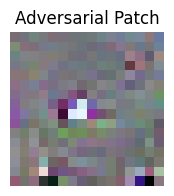

Attack Success Rate: 100.00%


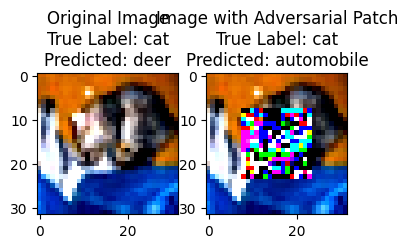

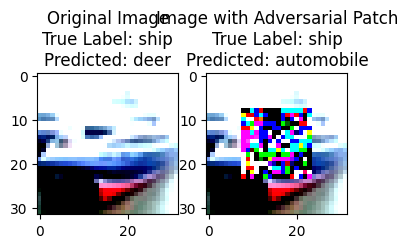

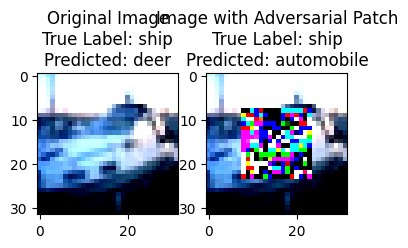

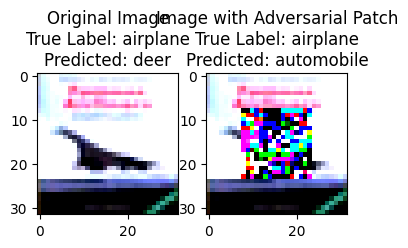

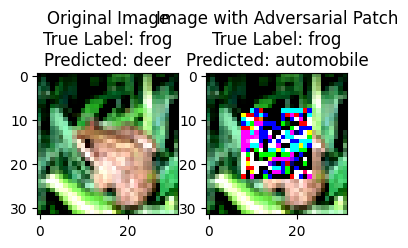


Training for patch size: (3, 3) with target class: bird
Epoch 1/20, Loss: 7.1031
Epoch 2/20, Loss: 2.1333
Epoch 3/20, Loss: 0.9545
Epoch 4/20, Loss: 0.6631
Epoch 5/20, Loss: 0.5374
Epoch 6/20, Loss: 0.4672
Epoch 7/20, Loss: 0.4180
Epoch 8/20, Loss: 0.3816
Epoch 9/20, Loss: 0.3584
Epoch 10/20, Loss: 0.3423
Epoch 11/20, Loss: 0.3260
Epoch 12/20, Loss: 0.3122
Epoch 13/20, Loss: 0.3023
Epoch 14/20, Loss: 0.2948
Epoch 15/20, Loss: 0.2862
Epoch 16/20, Loss: 0.2757
Epoch 17/20, Loss: 0.2677
Epoch 18/20, Loss: 0.2603
Epoch 19/20, Loss: 0.2522
Epoch 20/20, Loss: 0.2469
Visualizing patch of size (3, 3) for target class bird


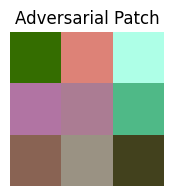

Attack Success Rate: 100.00%


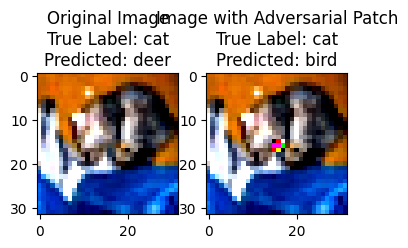

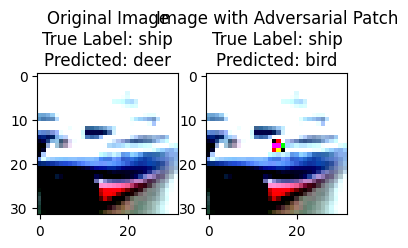

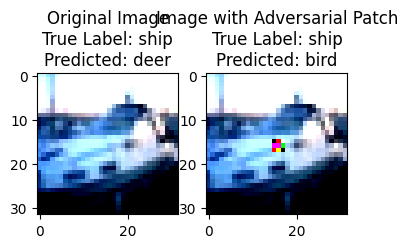

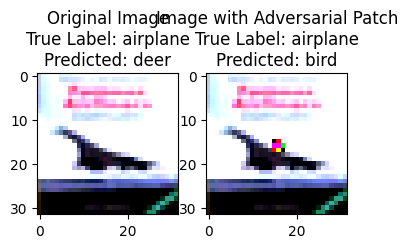

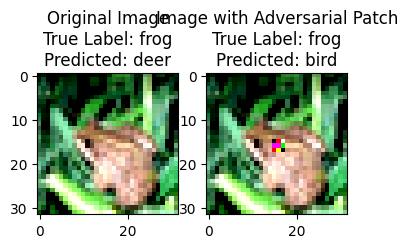


Training for patch size: (5, 5) with target class: bird
Epoch 1/20, Loss: 6.3428
Epoch 2/20, Loss: 1.5506
Epoch 3/20, Loss: 0.6641
Epoch 4/20, Loss: 0.4778
Epoch 5/20, Loss: 0.3937
Epoch 6/20, Loss: 0.3363
Epoch 7/20, Loss: 0.2934
Epoch 8/20, Loss: 0.2663
Epoch 9/20, Loss: 0.2449
Epoch 10/20, Loss: 0.2285
Epoch 11/20, Loss: 0.2167
Epoch 12/20, Loss: 0.2026
Epoch 13/20, Loss: 0.1893
Epoch 14/20, Loss: 0.1821
Epoch 15/20, Loss: 0.1775
Epoch 16/20, Loss: 0.1717
Epoch 17/20, Loss: 0.1666
Epoch 18/20, Loss: 0.1623
Epoch 19/20, Loss: 0.1592
Epoch 20/20, Loss: 0.1565
Visualizing patch of size (5, 5) for target class bird


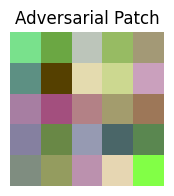

Attack Success Rate: 100.00%


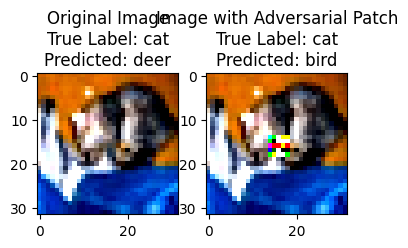

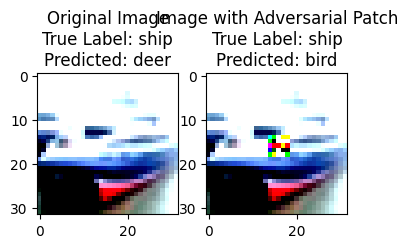

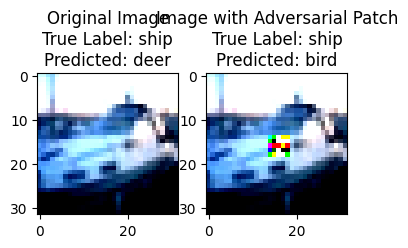

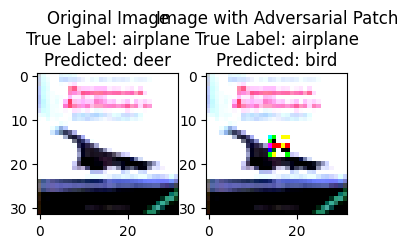

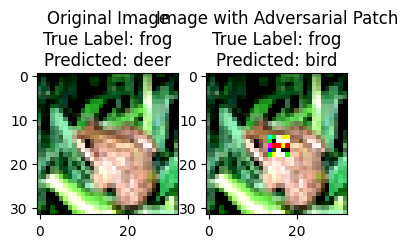


Training for patch size: (7, 7) with target class: bird
Epoch 1/20, Loss: 5.4909
Epoch 2/20, Loss: 1.6204
Epoch 3/20, Loss: 0.7901
Epoch 4/20, Loss: 0.5472
Epoch 5/20, Loss: 0.4259
Epoch 6/20, Loss: 0.3481
Epoch 7/20, Loss: 0.2931
Epoch 8/20, Loss: 0.2484
Epoch 9/20, Loss: 0.2111
Epoch 10/20, Loss: 0.1840
Epoch 11/20, Loss: 0.1695
Epoch 12/20, Loss: 0.1580
Epoch 13/20, Loss: 0.1328
Epoch 14/20, Loss: 0.1134
Epoch 15/20, Loss: 0.1045
Epoch 16/20, Loss: 0.0977
Epoch 17/20, Loss: 0.0922
Epoch 18/20, Loss: 0.0854
Epoch 19/20, Loss: 0.0803
Epoch 20/20, Loss: 0.0767
Visualizing patch of size (7, 7) for target class bird


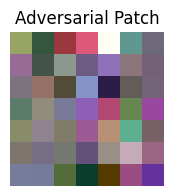

Attack Success Rate: 100.00%


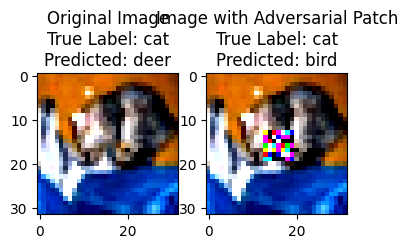

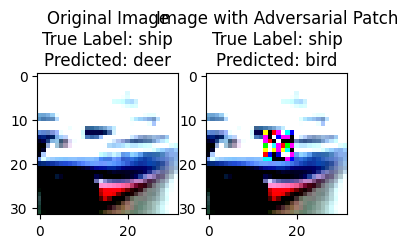

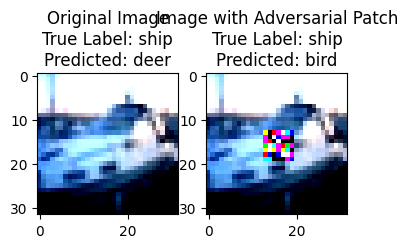

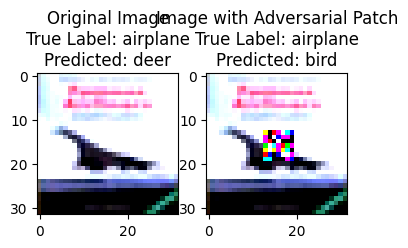

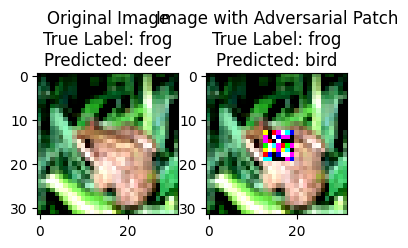


Training for patch size: (16, 16) with target class: bird
Epoch 1/20, Loss: 1.3490
Epoch 2/20, Loss: 0.4514
Epoch 3/20, Loss: 0.1900
Epoch 4/20, Loss: 0.1047
Epoch 5/20, Loss: 0.0649
Epoch 6/20, Loss: 0.0438
Epoch 7/20, Loss: 0.0335
Epoch 8/20, Loss: 0.0273
Epoch 9/20, Loss: 0.0228
Epoch 10/20, Loss: 0.0195
Epoch 11/20, Loss: 0.0170
Epoch 12/20, Loss: 0.0151
Epoch 13/20, Loss: 0.0135
Epoch 14/20, Loss: 0.0122
Epoch 15/20, Loss: 0.0111
Epoch 16/20, Loss: 0.0102
Epoch 17/20, Loss: 0.0095
Epoch 18/20, Loss: 0.0090
Epoch 19/20, Loss: 0.0085
Epoch 20/20, Loss: 0.0082
Visualizing patch of size (16, 16) for target class bird


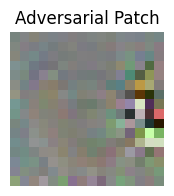

Attack Success Rate: 100.00%


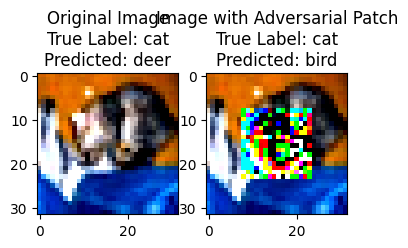

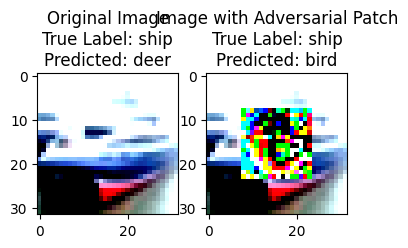

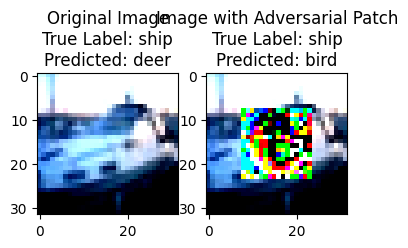

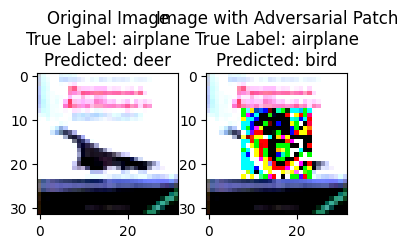

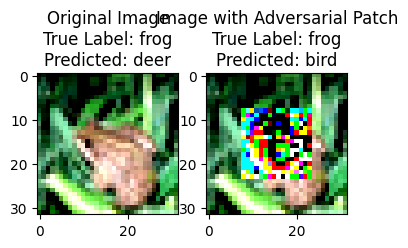


Training for patch size: (3, 3) with target class: cat
Epoch 1/20, Loss: 7.5395
Epoch 2/20, Loss: 4.0058
Epoch 3/20, Loss: 2.4542
Epoch 4/20, Loss: 2.0316
Epoch 5/20, Loss: 1.7907
Epoch 6/20, Loss: 1.6674
Epoch 7/20, Loss: 1.6050
Epoch 8/20, Loss: 1.5557
Epoch 9/20, Loss: 1.4883
Epoch 10/20, Loss: 1.4320
Epoch 11/20, Loss: 1.3660
Epoch 12/20, Loss: 1.3248
Epoch 13/20, Loss: 1.3114
Epoch 14/20, Loss: 1.3022
Epoch 15/20, Loss: 1.2941
Epoch 16/20, Loss: 1.2883
Epoch 17/20, Loss: 1.2830
Epoch 18/20, Loss: 1.2788
Epoch 19/20, Loss: 1.2748
Epoch 20/20, Loss: 1.2718
Visualizing patch of size (3, 3) for target class cat


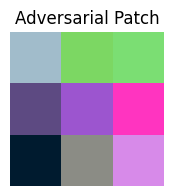

Attack Success Rate: 33.22%


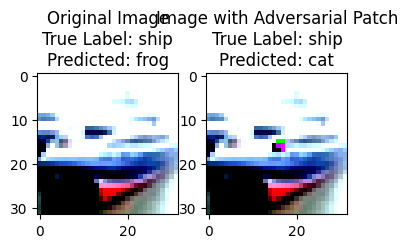

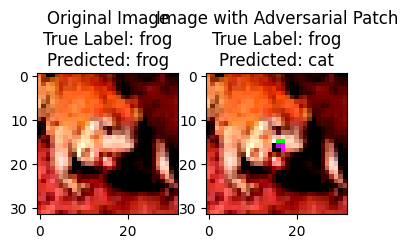

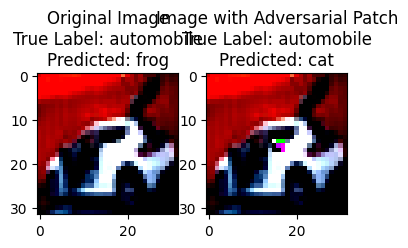

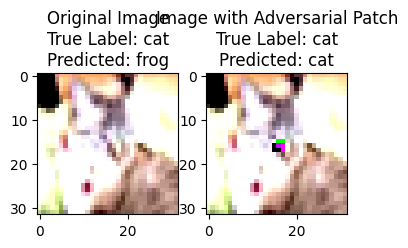

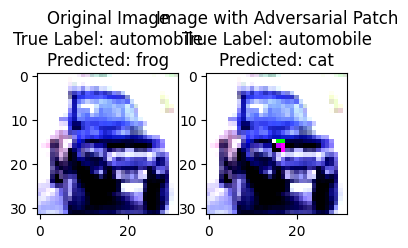


Training for patch size: (5, 5) with target class: cat
Epoch 1/20, Loss: 5.9587
Epoch 2/20, Loss: 3.5072
Epoch 3/20, Loss: 2.2977
Epoch 4/20, Loss: 1.8434
Epoch 5/20, Loss: 1.6164
Epoch 6/20, Loss: 1.4622
Epoch 7/20, Loss: 1.3425
Epoch 8/20, Loss: 1.2193
Epoch 9/20, Loss: 1.1499
Epoch 10/20, Loss: 1.1014
Epoch 11/20, Loss: 1.0666
Epoch 12/20, Loss: 1.0358
Epoch 13/20, Loss: 1.0142
Epoch 14/20, Loss: 0.9955
Epoch 15/20, Loss: 0.9798
Epoch 16/20, Loss: 0.9652
Epoch 17/20, Loss: 0.9496
Epoch 18/20, Loss: 0.9367
Epoch 19/20, Loss: 0.9165
Epoch 20/20, Loss: 0.8999
Visualizing patch of size (5, 5) for target class cat


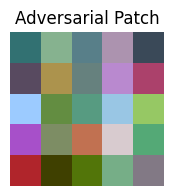

Attack Success Rate: 87.82%


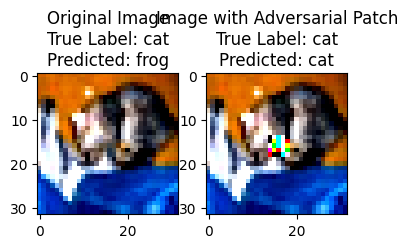

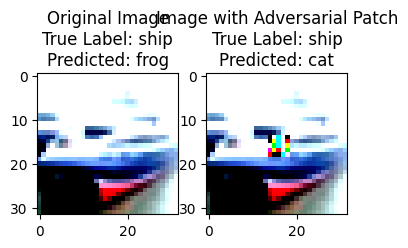

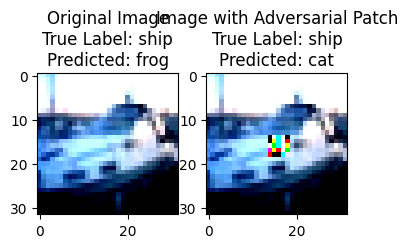

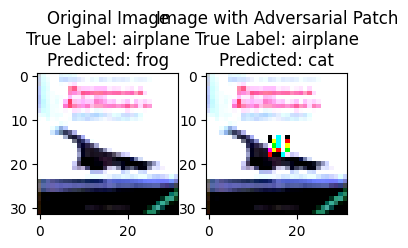

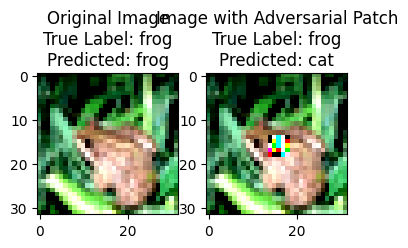


Training for patch size: (7, 7) with target class: cat
Epoch 1/20, Loss: 5.3217
Epoch 2/20, Loss: 2.5175
Epoch 3/20, Loss: 1.3926
Epoch 4/20, Loss: 1.0085
Epoch 5/20, Loss: 0.8249
Epoch 6/20, Loss: 0.7163
Epoch 7/20, Loss: 0.6351
Epoch 8/20, Loss: 0.5777
Epoch 9/20, Loss: 0.5366
Epoch 10/20, Loss: 0.4942
Epoch 11/20, Loss: 0.4534
Epoch 12/20, Loss: 0.4300
Epoch 13/20, Loss: 0.4120
Epoch 14/20, Loss: 0.3966
Epoch 15/20, Loss: 0.3844
Epoch 16/20, Loss: 0.3733
Epoch 17/20, Loss: 0.3635
Epoch 18/20, Loss: 0.3555
Epoch 19/20, Loss: 0.3487
Epoch 20/20, Loss: 0.3425
Visualizing patch of size (7, 7) for target class cat


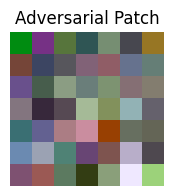

Attack Success Rate: 99.90%


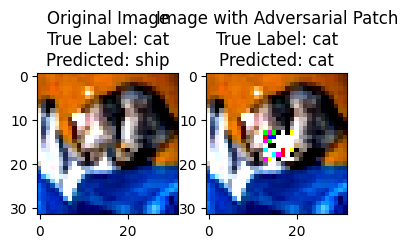

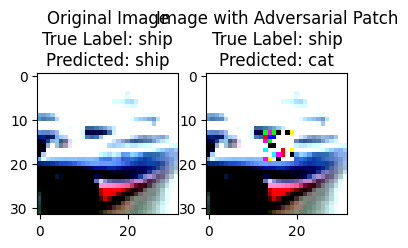

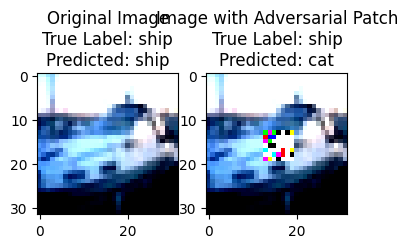

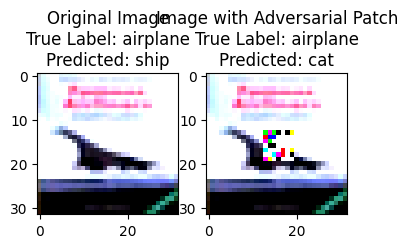

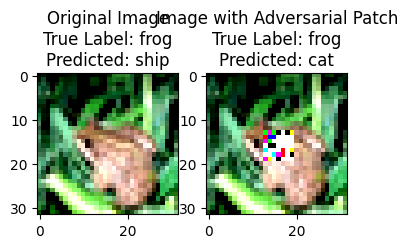


Training for patch size: (16, 16) with target class: cat
Epoch 1/20, Loss: 1.1026
Epoch 2/20, Loss: 0.3416
Epoch 3/20, Loss: 0.1757
Epoch 4/20, Loss: 0.1115
Epoch 5/20, Loss: 0.0798
Epoch 6/20, Loss: 0.0614
Epoch 7/20, Loss: 0.0478
Epoch 8/20, Loss: 0.0367
Epoch 9/20, Loss: 0.0292
Epoch 10/20, Loss: 0.0242
Epoch 11/20, Loss: 0.0210
Epoch 12/20, Loss: 0.0190
Epoch 13/20, Loss: 0.0173
Epoch 14/20, Loss: 0.0160
Epoch 15/20, Loss: 0.0150
Epoch 16/20, Loss: 0.0138
Epoch 17/20, Loss: 0.0129
Epoch 18/20, Loss: 0.0122
Epoch 19/20, Loss: 0.0117
Epoch 20/20, Loss: 0.0112
Visualizing patch of size (16, 16) for target class cat


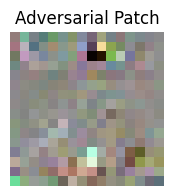

Attack Success Rate: 100.00%


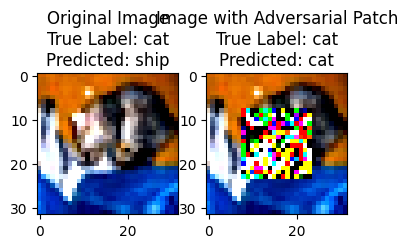

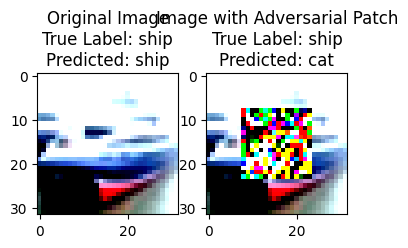

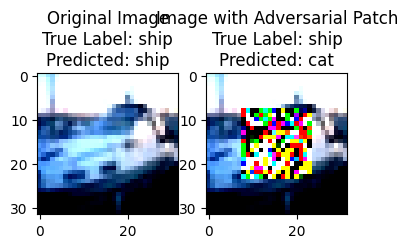

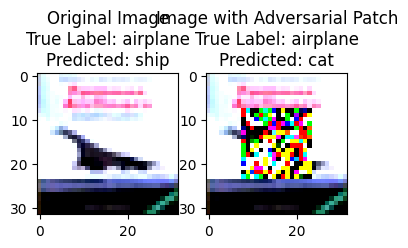

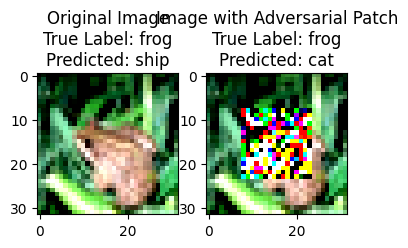


Training for patch size: (3, 3) with target class: deer
Epoch 1/20, Loss: 9.1501
Epoch 2/20, Loss: 6.2865
Epoch 3/20, Loss: 4.3397
Epoch 4/20, Loss: 3.8115
Epoch 5/20, Loss: 3.5854
Epoch 6/20, Loss: 3.4356
Epoch 7/20, Loss: 3.3456
Epoch 8/20, Loss: 3.2870
Epoch 9/20, Loss: 3.2456
Epoch 10/20, Loss: 3.2113
Epoch 11/20, Loss: 3.1854
Epoch 12/20, Loss: 3.1672
Epoch 13/20, Loss: 3.1534
Epoch 14/20, Loss: 3.1405
Epoch 15/20, Loss: 3.1245
Epoch 16/20, Loss: 3.1095
Epoch 17/20, Loss: 3.0929
Epoch 18/20, Loss: 3.0793
Epoch 19/20, Loss: 3.0665
Epoch 20/20, Loss: 3.0554
Visualizing patch of size (3, 3) for target class deer


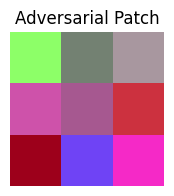

Attack Success Rate: 0.01%


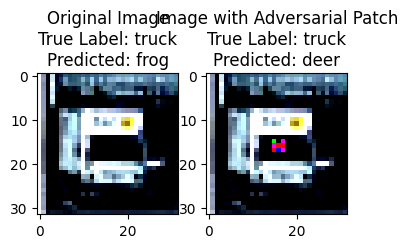


Training for patch size: (5, 5) with target class: deer
Epoch 1/20, Loss: 8.9115
Epoch 2/20, Loss: 5.0247
Epoch 3/20, Loss: 3.4764
Epoch 4/20, Loss: 3.0613
Epoch 5/20, Loss: 2.8930
Epoch 6/20, Loss: 2.7741
Epoch 7/20, Loss: 2.6951
Epoch 8/20, Loss: 2.6437
Epoch 9/20, Loss: 2.6074
Epoch 10/20, Loss: 2.5835
Epoch 11/20, Loss: 2.5617
Epoch 12/20, Loss: 2.5458
Epoch 13/20, Loss: 2.5357
Epoch 14/20, Loss: 2.5266
Epoch 15/20, Loss: 2.5173
Epoch 16/20, Loss: 2.5109
Epoch 17/20, Loss: 2.5067
Epoch 18/20, Loss: 2.5023
Epoch 19/20, Loss: 2.4985
Epoch 20/20, Loss: 2.4944
Visualizing patch of size (5, 5) for target class deer


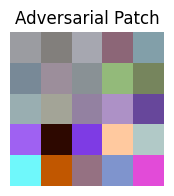

Attack Success Rate: 0.00%

Training for patch size: (7, 7) with target class: deer
Epoch 1/20, Loss: 7.6986
Epoch 2/20, Loss: 5.3073
Epoch 3/20, Loss: 3.5066
Epoch 4/20, Loss: 2.7647
Epoch 5/20, Loss: 2.4347
Epoch 6/20, Loss: 2.1008
Epoch 7/20, Loss: 1.7238
Epoch 8/20, Loss: 1.4963
Epoch 9/20, Loss: 1.3613
Epoch 10/20, Loss: 1.2480
Epoch 11/20, Loss: 1.1363
Epoch 12/20, Loss: 1.0316
Epoch 13/20, Loss: 0.9585
Epoch 14/20, Loss: 0.9165
Epoch 15/20, Loss: 0.8784
Epoch 16/20, Loss: 0.8469
Epoch 17/20, Loss: 0.8123
Epoch 18/20, Loss: 0.7938
Epoch 19/20, Loss: 0.7814
Epoch 20/20, Loss: 0.7676
Visualizing patch of size (7, 7) for target class deer


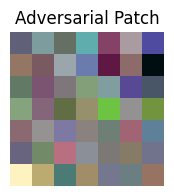

Attack Success Rate: 96.87%


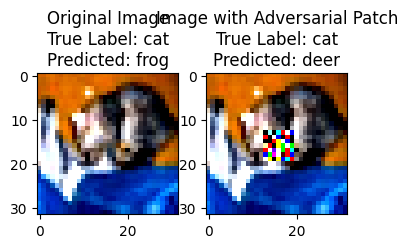

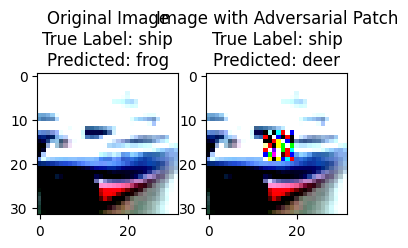

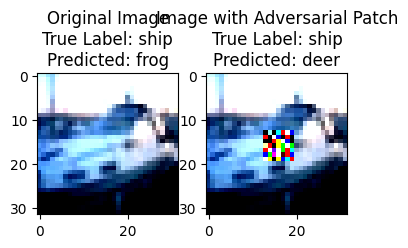

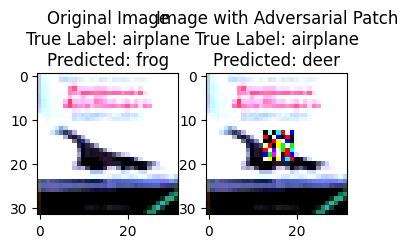

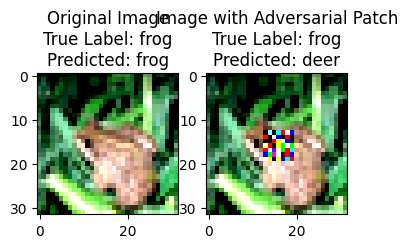


Training for patch size: (16, 16) with target class: deer
Epoch 1/20, Loss: 2.3585
Epoch 2/20, Loss: 0.7046
Epoch 3/20, Loss: 0.3459
Epoch 4/20, Loss: 0.1868
Epoch 5/20, Loss: 0.1199
Epoch 6/20, Loss: 0.0868
Epoch 7/20, Loss: 0.0671
Epoch 8/20, Loss: 0.0549
Epoch 9/20, Loss: 0.0458
Epoch 10/20, Loss: 0.0392
Epoch 11/20, Loss: 0.0349
Epoch 12/20, Loss: 0.0314
Epoch 13/20, Loss: 0.0285
Epoch 14/20, Loss: 0.0264
Epoch 15/20, Loss: 0.0248
Epoch 16/20, Loss: 0.0233
Epoch 17/20, Loss: 0.0222
Epoch 18/20, Loss: 0.0210
Epoch 19/20, Loss: 0.0198
Epoch 20/20, Loss: 0.0185
Visualizing patch of size (16, 16) for target class deer


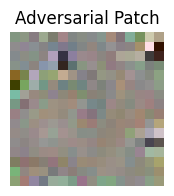

Attack Success Rate: 100.00%


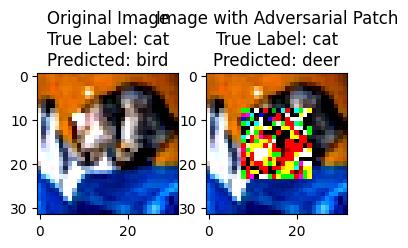

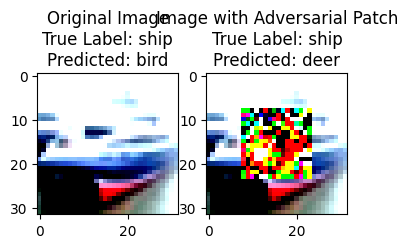

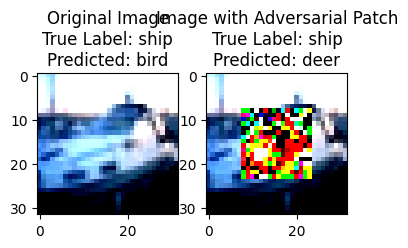

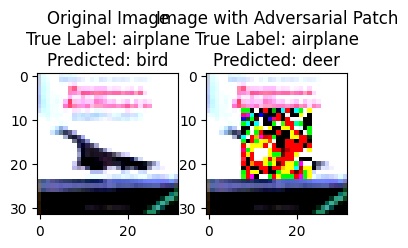

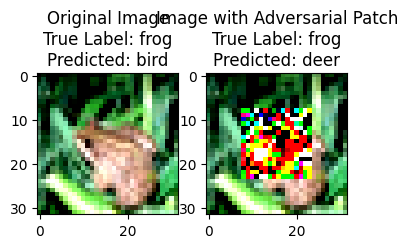


Training for patch size: (3, 3) with target class: dog
Epoch 1/20, Loss: 8.0839
Epoch 2/20, Loss: 5.1824
Epoch 3/20, Loss: 3.3928
Epoch 4/20, Loss: 2.6435
Epoch 5/20, Loss: 2.3528
Epoch 6/20, Loss: 2.2280
Epoch 7/20, Loss: 2.1551
Epoch 8/20, Loss: 2.1023
Epoch 9/20, Loss: 2.0640
Epoch 10/20, Loss: 2.0394
Epoch 11/20, Loss: 2.0212
Epoch 12/20, Loss: 2.0078
Epoch 13/20, Loss: 1.9983
Epoch 14/20, Loss: 1.9909
Epoch 15/20, Loss: 1.9846
Epoch 16/20, Loss: 1.9794
Epoch 17/20, Loss: 1.9746
Epoch 18/20, Loss: 1.9693
Epoch 19/20, Loss: 1.9635
Epoch 20/20, Loss: 1.9524
Visualizing patch of size (3, 3) for target class dog


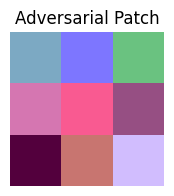

Attack Success Rate: 0.09%


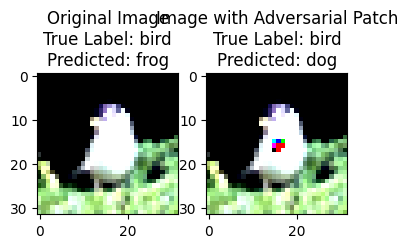

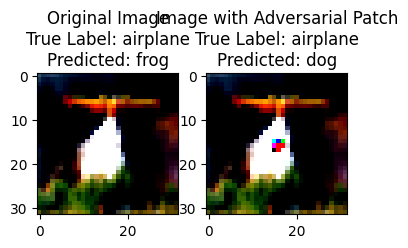

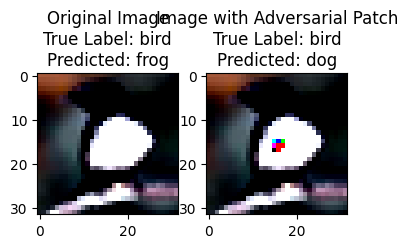

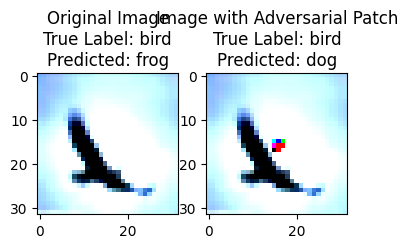

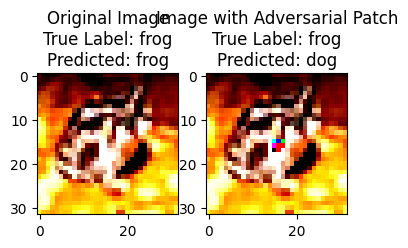


Training for patch size: (5, 5) with target class: dog
Epoch 1/20, Loss: 7.0488
Epoch 2/20, Loss: 5.4528
Epoch 3/20, Loss: 3.4749
Epoch 4/20, Loss: 2.6830
Epoch 5/20, Loss: 2.3181
Epoch 6/20, Loss: 2.0930
Epoch 7/20, Loss: 1.9291
Epoch 8/20, Loss: 1.8234
Epoch 9/20, Loss: 1.7578
Epoch 10/20, Loss: 1.6954
Epoch 11/20, Loss: 1.6468
Epoch 12/20, Loss: 1.6135
Epoch 13/20, Loss: 1.5850
Epoch 14/20, Loss: 1.5633
Epoch 15/20, Loss: 1.5508
Epoch 16/20, Loss: 1.5371
Epoch 17/20, Loss: 1.5236
Epoch 18/20, Loss: 1.5129
Epoch 19/20, Loss: 1.5055
Epoch 20/20, Loss: 1.5003
Visualizing patch of size (5, 5) for target class dog


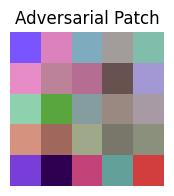

Attack Success Rate: 7.50%


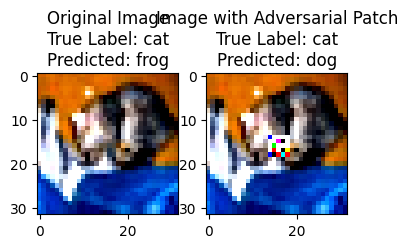

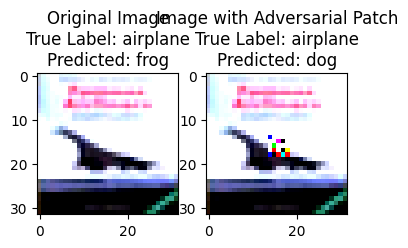

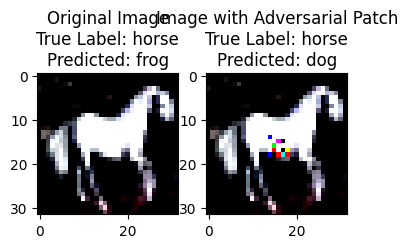

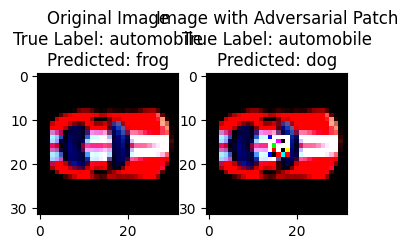

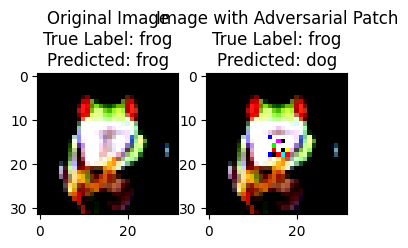


Training for patch size: (7, 7) with target class: dog
Epoch 1/20, Loss: 5.4355
Epoch 2/20, Loss: 2.9810
Epoch 3/20, Loss: 1.6385
Epoch 4/20, Loss: 1.1490
Epoch 5/20, Loss: 0.8846
Epoch 6/20, Loss: 0.7064
Epoch 7/20, Loss: 0.6008
Epoch 8/20, Loss: 0.5311
Epoch 9/20, Loss: 0.4836
Epoch 10/20, Loss: 0.4409
Epoch 11/20, Loss: 0.3983
Epoch 12/20, Loss: 0.3682
Epoch 13/20, Loss: 0.3466
Epoch 14/20, Loss: 0.3296
Epoch 15/20, Loss: 0.3154
Epoch 16/20, Loss: 0.3034
Epoch 17/20, Loss: 0.2938
Epoch 18/20, Loss: 0.2853
Epoch 19/20, Loss: 0.2775
Epoch 20/20, Loss: 0.2712
Visualizing patch of size (7, 7) for target class dog


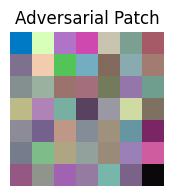

Attack Success Rate: 99.95%


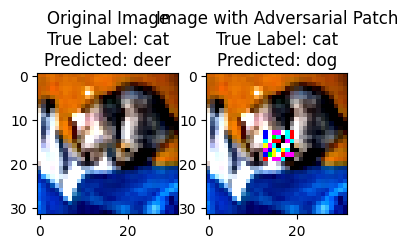

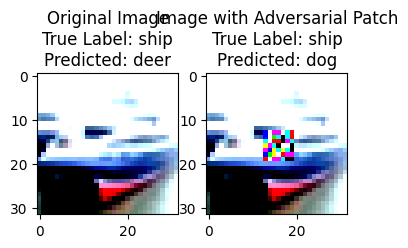

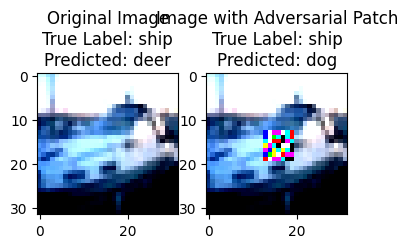

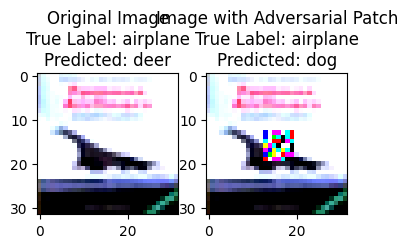

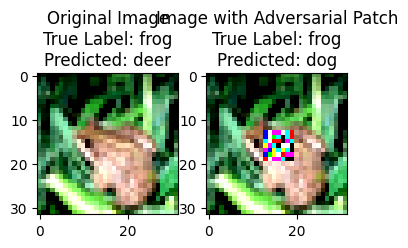


Training for patch size: (16, 16) with target class: dog
Epoch 1/20, Loss: 0.9289
Epoch 2/20, Loss: 0.2261
Epoch 3/20, Loss: 0.1022
Epoch 4/20, Loss: 0.0590
Epoch 5/20, Loss: 0.0395
Epoch 6/20, Loss: 0.0289
Epoch 7/20, Loss: 0.0220
Epoch 8/20, Loss: 0.0176
Epoch 9/20, Loss: 0.0143
Epoch 10/20, Loss: 0.0122
Epoch 11/20, Loss: 0.0105
Epoch 12/20, Loss: 0.0093
Epoch 13/20, Loss: 0.0080
Epoch 14/20, Loss: 0.0069
Epoch 15/20, Loss: 0.0062
Epoch 16/20, Loss: 0.0057
Epoch 17/20, Loss: 0.0053
Epoch 18/20, Loss: 0.0050
Epoch 19/20, Loss: 0.0047
Epoch 20/20, Loss: 0.0045
Visualizing patch of size (16, 16) for target class dog


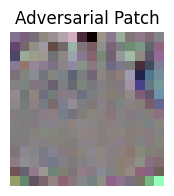

Attack Success Rate: 100.00%


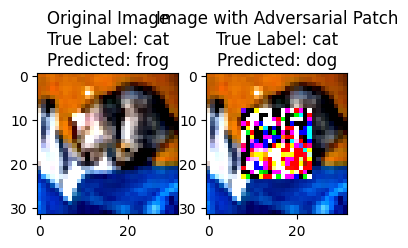

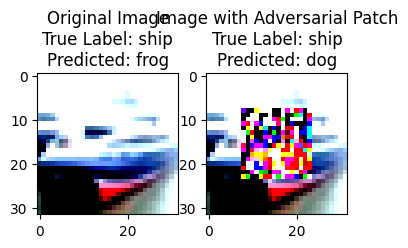

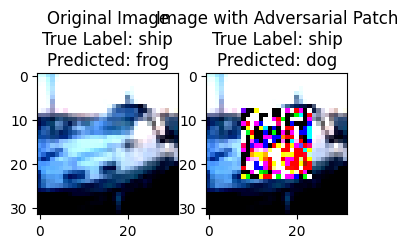

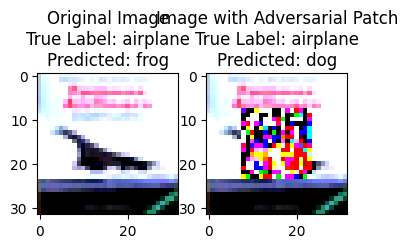

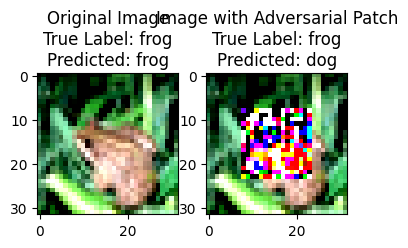


Training for patch size: (3, 3) with target class: frog
Epoch 1/20, Loss: 9.3777
Epoch 2/20, Loss: 5.4411
Epoch 3/20, Loss: 4.3505
Epoch 4/20, Loss: 4.0036
Epoch 5/20, Loss: 3.8090
Epoch 6/20, Loss: 3.6691
Epoch 7/20, Loss: 3.5899
Epoch 8/20, Loss: 3.5435
Epoch 9/20, Loss: 3.5121
Epoch 10/20, Loss: 3.4849
Epoch 11/20, Loss: 3.4634
Epoch 12/20, Loss: 3.4422
Epoch 13/20, Loss: 3.4207
Epoch 14/20, Loss: 3.4061
Epoch 15/20, Loss: 3.3881
Epoch 16/20, Loss: 3.3642
Epoch 17/20, Loss: 3.3390
Epoch 18/20, Loss: 3.3240
Epoch 19/20, Loss: 3.3148
Epoch 20/20, Loss: 3.3073
Visualizing patch of size (3, 3) for target class frog


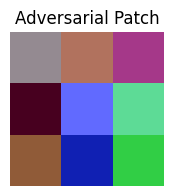

Attack Success Rate: 0.00%

Training for patch size: (5, 5) with target class: frog
Epoch 1/20, Loss: 9.3212
Epoch 2/20, Loss: 5.6569
Epoch 3/20, Loss: 4.4554
Epoch 4/20, Loss: 3.8303
Epoch 5/20, Loss: 3.5394
Epoch 6/20, Loss: 3.3957
Epoch 7/20, Loss: 3.3172
Epoch 8/20, Loss: 3.2661
Epoch 9/20, Loss: 3.2333
Epoch 10/20, Loss: 3.2099
Epoch 11/20, Loss: 3.1915
Epoch 12/20, Loss: 3.1738
Epoch 13/20, Loss: 3.1522
Epoch 14/20, Loss: 3.1374
Epoch 15/20, Loss: 3.1165
Epoch 16/20, Loss: 3.0956
Epoch 17/20, Loss: 3.0843
Epoch 18/20, Loss: 3.0730
Epoch 19/20, Loss: 3.0583
Epoch 20/20, Loss: 3.0303
Visualizing patch of size (5, 5) for target class frog


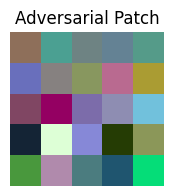

Attack Success Rate: 0.00%

Training for patch size: (7, 7) with target class: frog
Epoch 1/20, Loss: 7.7266
Epoch 2/20, Loss: 5.5022
Epoch 3/20, Loss: 4.4381
Epoch 4/20, Loss: 3.7893
Epoch 5/20, Loss: 3.4178
Epoch 6/20, Loss: 3.1140
Epoch 7/20, Loss: 2.8898
Epoch 8/20, Loss: 2.7193
Epoch 9/20, Loss: 2.5658
Epoch 10/20, Loss: 2.4668
Epoch 11/20, Loss: 2.3675
Epoch 12/20, Loss: 2.1806
Epoch 13/20, Loss: 2.0590
Epoch 14/20, Loss: 2.0055
Epoch 15/20, Loss: 1.9704
Epoch 16/20, Loss: 1.9381
Epoch 17/20, Loss: 1.9137
Epoch 18/20, Loss: 1.8915
Epoch 19/20, Loss: 1.8744
Epoch 20/20, Loss: 1.8593
Visualizing patch of size (7, 7) for target class frog


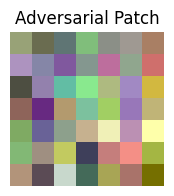

Attack Success Rate: 25.17%


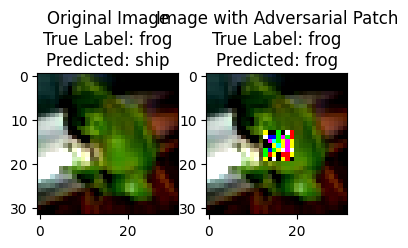

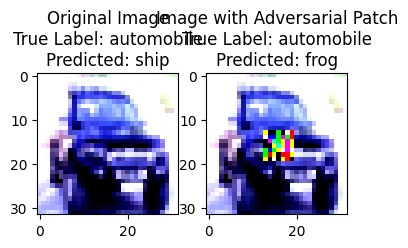

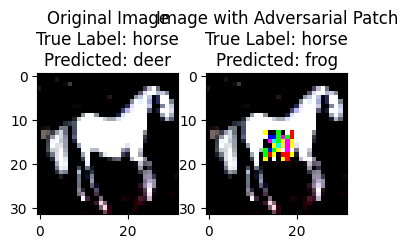

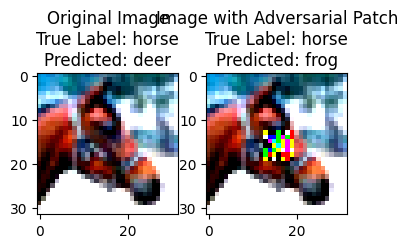

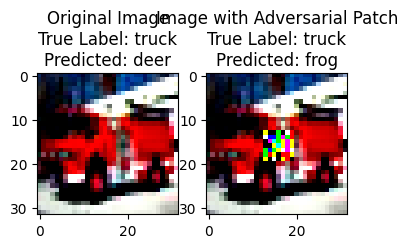


Training for patch size: (16, 16) with target class: frog
Epoch 1/20, Loss: 1.8548
Epoch 2/20, Loss: 0.6837
Epoch 3/20, Loss: 0.3782
Epoch 4/20, Loss: 0.2425
Epoch 5/20, Loss: 0.1676
Epoch 6/20, Loss: 0.1269
Epoch 7/20, Loss: 0.1005
Epoch 8/20, Loss: 0.0827
Epoch 9/20, Loss: 0.0683
Epoch 10/20, Loss: 0.0590
Epoch 11/20, Loss: 0.0528
Epoch 12/20, Loss: 0.0477
Epoch 13/20, Loss: 0.0439
Epoch 14/20, Loss: 0.0398
Epoch 15/20, Loss: 0.0367
Epoch 16/20, Loss: 0.0340
Epoch 17/20, Loss: 0.0318
Epoch 18/20, Loss: 0.0296
Epoch 19/20, Loss: 0.0276
Epoch 20/20, Loss: 0.0256
Visualizing patch of size (16, 16) for target class frog


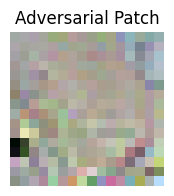

Attack Success Rate: 99.99%


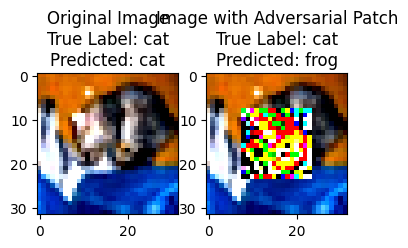

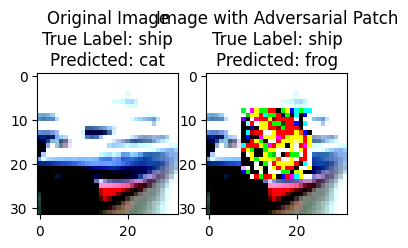

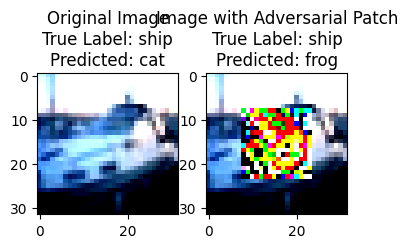

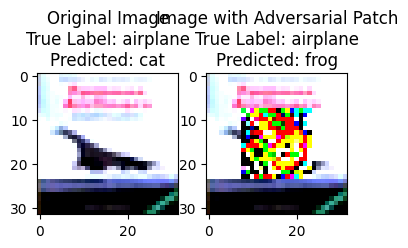

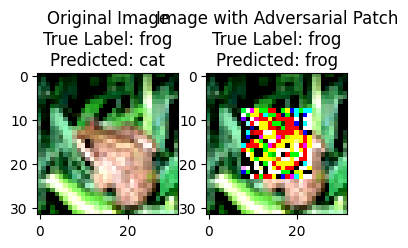


Training for patch size: (3, 3) with target class: horse
Epoch 1/20, Loss: 9.2747
Epoch 2/20, Loss: 5.7244
Epoch 3/20, Loss: 4.3255
Epoch 4/20, Loss: 3.9854
Epoch 5/20, Loss: 3.8125
Epoch 6/20, Loss: 3.7127
Epoch 7/20, Loss: 3.6536
Epoch 8/20, Loss: 3.6093
Epoch 9/20, Loss: 3.5499
Epoch 10/20, Loss: 3.4900
Epoch 11/20, Loss: 3.4571
Epoch 12/20, Loss: 3.4330
Epoch 13/20, Loss: 3.4114
Epoch 14/20, Loss: 3.3907
Epoch 15/20, Loss: 3.3721
Epoch 16/20, Loss: 3.3617
Epoch 17/20, Loss: 3.3497
Epoch 18/20, Loss: 3.3413
Epoch 19/20, Loss: 3.3310
Epoch 20/20, Loss: 3.2909
Visualizing patch of size (3, 3) for target class horse


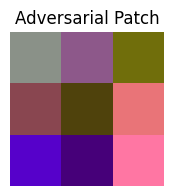

Attack Success Rate: 0.00%

Training for patch size: (5, 5) with target class: horse
Epoch 1/20, Loss: 8.3373
Epoch 2/20, Loss: 5.1056
Epoch 3/20, Loss: 3.8196
Epoch 4/20, Loss: 3.3994
Epoch 5/20, Loss: 3.0402
Epoch 6/20, Loss: 2.8333
Epoch 7/20, Loss: 2.7324
Epoch 8/20, Loss: 2.6718
Epoch 9/20, Loss: 2.6227
Epoch 10/20, Loss: 2.5664
Epoch 11/20, Loss: 2.5104
Epoch 12/20, Loss: 2.4668
Epoch 13/20, Loss: 2.4152
Epoch 14/20, Loss: 2.3854
Epoch 15/20, Loss: 2.3689
Epoch 16/20, Loss: 2.3550
Epoch 17/20, Loss: 2.3440
Epoch 18/20, Loss: 2.3343
Epoch 19/20, Loss: 2.3255
Epoch 20/20, Loss: 2.3180
Visualizing patch of size (5, 5) for target class horse


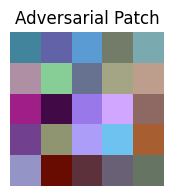

Attack Success Rate: 0.00%

Training for patch size: (7, 7) with target class: horse
Epoch 1/20, Loss: 7.9950
Epoch 2/20, Loss: 5.3555
Epoch 3/20, Loss: 4.0494
Epoch 4/20, Loss: 3.1130
Epoch 5/20, Loss: 2.5178
Epoch 6/20, Loss: 2.1994
Epoch 7/20, Loss: 2.0021
Epoch 8/20, Loss: 1.8620
Epoch 9/20, Loss: 1.6745
Epoch 10/20, Loss: 1.5659
Epoch 11/20, Loss: 1.5011
Epoch 12/20, Loss: 1.4555
Epoch 13/20, Loss: 1.4182
Epoch 14/20, Loss: 1.3571
Epoch 15/20, Loss: 1.2531
Epoch 16/20, Loss: 1.1635
Epoch 17/20, Loss: 1.0845
Epoch 18/20, Loss: 1.0010
Epoch 19/20, Loss: 0.9563
Epoch 20/20, Loss: 0.9182
Visualizing patch of size (7, 7) for target class horse


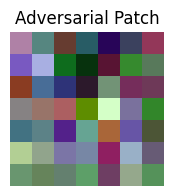

Attack Success Rate: 98.16%


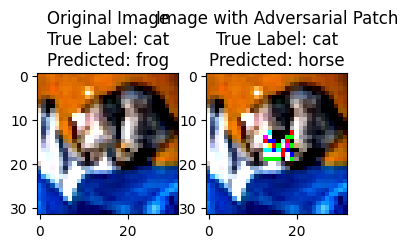

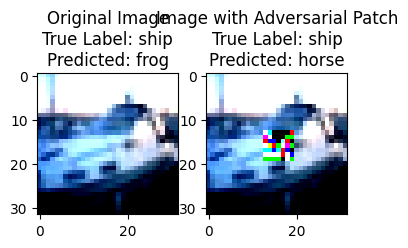

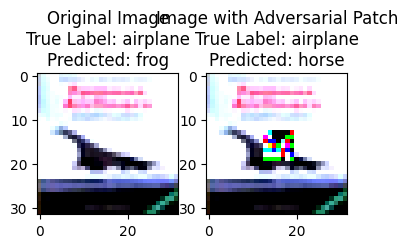

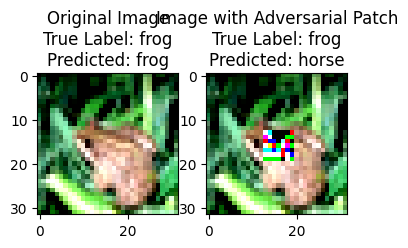

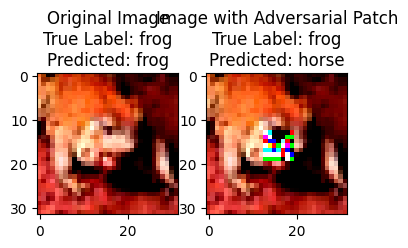


Training for patch size: (16, 16) with target class: horse
Epoch 1/20, Loss: 1.6763
Epoch 2/20, Loss: 0.5074
Epoch 3/20, Loss: 0.2423
Epoch 4/20, Loss: 0.1478
Epoch 5/20, Loss: 0.0966
Epoch 6/20, Loss: 0.0662
Epoch 7/20, Loss: 0.0495
Epoch 8/20, Loss: 0.0394
Epoch 9/20, Loss: 0.0321
Epoch 10/20, Loss: 0.0275
Epoch 11/20, Loss: 0.0243
Epoch 12/20, Loss: 0.0217
Epoch 13/20, Loss: 0.0194
Epoch 14/20, Loss: 0.0172
Epoch 15/20, Loss: 0.0155
Epoch 16/20, Loss: 0.0141
Epoch 17/20, Loss: 0.0128
Epoch 18/20, Loss: 0.0118
Epoch 19/20, Loss: 0.0110
Epoch 20/20, Loss: 0.0104
Visualizing patch of size (16, 16) for target class horse


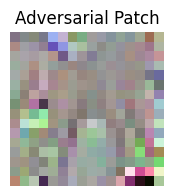

Attack Success Rate: 100.00%


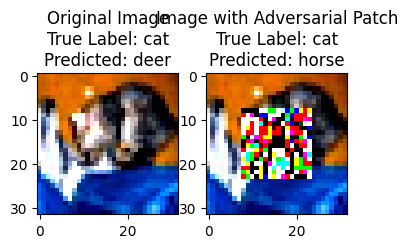

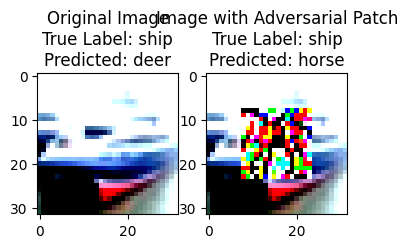

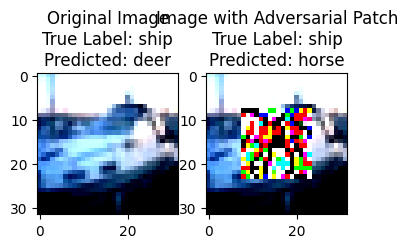

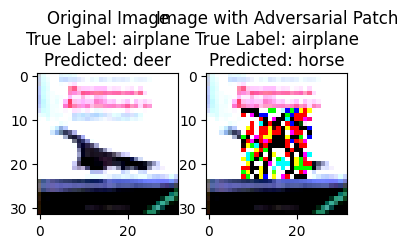

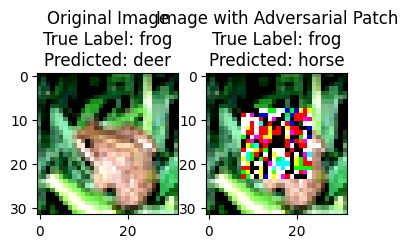


Training for patch size: (3, 3) with target class: ship
Epoch 1/20, Loss: 9.7134
Epoch 2/20, Loss: 7.7007
Epoch 3/20, Loss: 6.3036
Epoch 4/20, Loss: 5.7590
Epoch 5/20, Loss: 5.4408
Epoch 6/20, Loss: 5.1995
Epoch 7/20, Loss: 5.0503
Epoch 8/20, Loss: 4.9290
Epoch 9/20, Loss: 4.8699
Epoch 10/20, Loss: 4.8364
Epoch 11/20, Loss: 4.8137
Epoch 12/20, Loss: 4.7967
Epoch 13/20, Loss: 4.7839
Epoch 14/20, Loss: 4.7733
Epoch 15/20, Loss: 4.7633
Epoch 16/20, Loss: 4.7552
Epoch 17/20, Loss: 4.7475
Epoch 18/20, Loss: 4.7421
Epoch 19/20, Loss: 4.7378
Epoch 20/20, Loss: 4.7333
Visualizing patch of size (3, 3) for target class ship


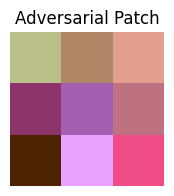

Attack Success Rate: 0.00%

Training for patch size: (5, 5) with target class: ship
Epoch 1/20, Loss: 8.7149
Epoch 2/20, Loss: 6.8160
Epoch 3/20, Loss: 5.7858
Epoch 4/20, Loss: 5.1423
Epoch 5/20, Loss: 4.7993
Epoch 6/20, Loss: 4.5972
Epoch 7/20, Loss: 4.4653
Epoch 8/20, Loss: 4.3465
Epoch 9/20, Loss: 4.2477
Epoch 10/20, Loss: 4.1733
Epoch 11/20, Loss: 4.1244
Epoch 12/20, Loss: 4.0877
Epoch 13/20, Loss: 4.0485
Epoch 14/20, Loss: 3.9848
Epoch 15/20, Loss: 3.9298
Epoch 16/20, Loss: 3.8972
Epoch 17/20, Loss: 3.8729
Epoch 18/20, Loss: 3.8518
Epoch 19/20, Loss: 3.8335
Epoch 20/20, Loss: 3.8208
Visualizing patch of size (5, 5) for target class ship


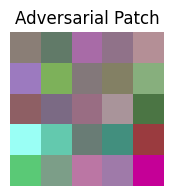

Attack Success Rate: 0.00%

Training for patch size: (7, 7) with target class: ship
Epoch 1/20, Loss: 7.3349
Epoch 2/20, Loss: 5.2911
Epoch 3/20, Loss: 3.9809
Epoch 4/20, Loss: 3.2567
Epoch 5/20, Loss: 2.7715
Epoch 6/20, Loss: 2.4698
Epoch 7/20, Loss: 2.2566
Epoch 8/20, Loss: 2.1048
Epoch 9/20, Loss: 1.9862
Epoch 10/20, Loss: 1.8866
Epoch 11/20, Loss: 1.8104
Epoch 12/20, Loss: 1.7520
Epoch 13/20, Loss: 1.7051
Epoch 14/20, Loss: 1.6654
Epoch 15/20, Loss: 1.6335
Epoch 16/20, Loss: 1.6019
Epoch 17/20, Loss: 1.5726
Epoch 18/20, Loss: 1.5433
Epoch 19/20, Loss: 1.5130
Epoch 20/20, Loss: 1.4857
Visualizing patch of size (7, 7) for target class ship


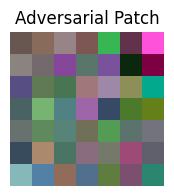

Attack Success Rate: 55.37%


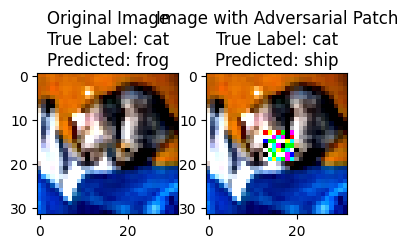

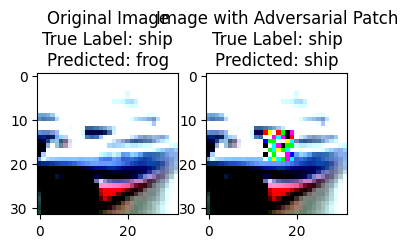

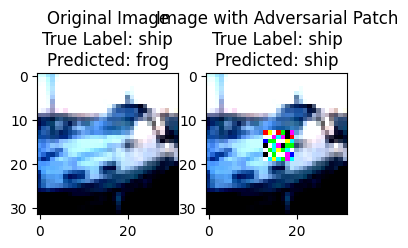

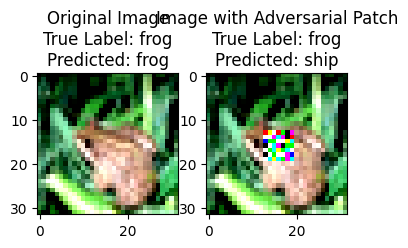

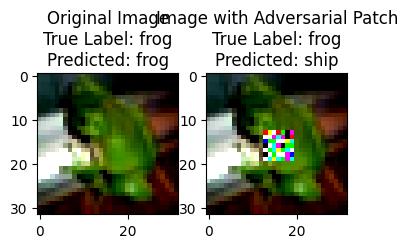


Training for patch size: (16, 16) with target class: ship
Epoch 1/20, Loss: 1.8408
Epoch 2/20, Loss: 0.7110
Epoch 3/20, Loss: 0.3162
Epoch 4/20, Loss: 0.1685
Epoch 5/20, Loss: 0.1024
Epoch 6/20, Loss: 0.0684
Epoch 7/20, Loss: 0.0491
Epoch 8/20, Loss: 0.0379
Epoch 9/20, Loss: 0.0306
Epoch 10/20, Loss: 0.0259
Epoch 11/20, Loss: 0.0225
Epoch 12/20, Loss: 0.0200
Epoch 13/20, Loss: 0.0179
Epoch 14/20, Loss: 0.0161
Epoch 15/20, Loss: 0.0146
Epoch 16/20, Loss: 0.0133
Epoch 17/20, Loss: 0.0122
Epoch 18/20, Loss: 0.0111
Epoch 19/20, Loss: 0.0101
Epoch 20/20, Loss: 0.0092
Visualizing patch of size (16, 16) for target class ship


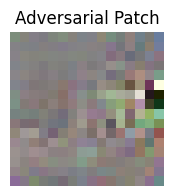

Attack Success Rate: 100.00%


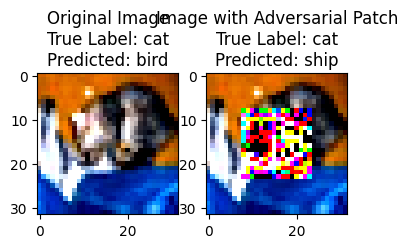

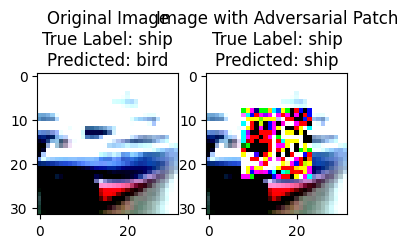

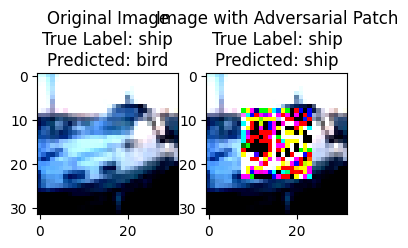

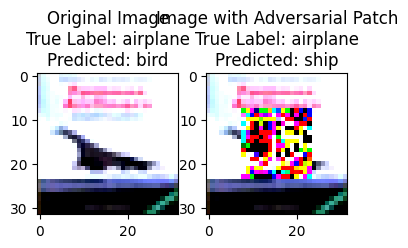

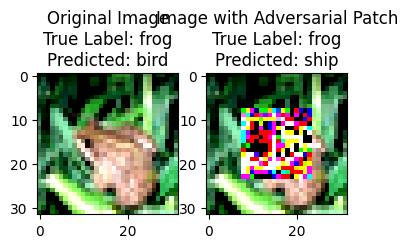


Training for patch size: (3, 3) with target class: truck
Epoch 1/20, Loss: 9.2280
Epoch 2/20, Loss: 6.0237
Epoch 3/20, Loss: 4.8401
Epoch 4/20, Loss: 4.3859
Epoch 5/20, Loss: 4.0814
Epoch 6/20, Loss: 3.9052
Epoch 7/20, Loss: 3.7977
Epoch 8/20, Loss: 3.6841
Epoch 9/20, Loss: 3.6359
Epoch 10/20, Loss: 3.6022
Epoch 11/20, Loss: 3.5726
Epoch 12/20, Loss: 3.5526
Epoch 13/20, Loss: 3.5216
Epoch 14/20, Loss: 3.4813
Epoch 15/20, Loss: 3.4452
Epoch 16/20, Loss: 3.4134
Epoch 17/20, Loss: 3.3864
Epoch 18/20, Loss: 3.3491
Epoch 19/20, Loss: 3.3320
Epoch 20/20, Loss: 3.3217
Visualizing patch of size (3, 3) for target class truck


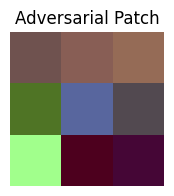

Attack Success Rate: 0.00%

Training for patch size: (5, 5) with target class: truck
Epoch 1/20, Loss: 8.7104
Epoch 2/20, Loss: 5.1427
Epoch 3/20, Loss: 3.8240
Epoch 4/20, Loss: 3.3667
Epoch 5/20, Loss: 3.1667
Epoch 6/20, Loss: 3.0682
Epoch 7/20, Loss: 3.0093
Epoch 8/20, Loss: 2.9496
Epoch 9/20, Loss: 2.8884
Epoch 10/20, Loss: 2.8529
Epoch 11/20, Loss: 2.8319
Epoch 12/20, Loss: 2.8157
Epoch 13/20, Loss: 2.8042
Epoch 14/20, Loss: 2.7946
Epoch 15/20, Loss: 2.7865
Epoch 16/20, Loss: 2.7796
Epoch 17/20, Loss: 2.7738
Epoch 18/20, Loss: 2.7690
Epoch 19/20, Loss: 2.7650
Epoch 20/20, Loss: 2.7613
Visualizing patch of size (5, 5) for target class truck


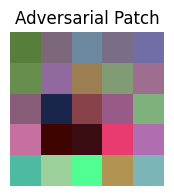

Attack Success Rate: 0.00%

Training for patch size: (7, 7) with target class: truck
Epoch 1/20, Loss: 7.1133
Epoch 2/20, Loss: 4.9001
Epoch 3/20, Loss: 3.6898
Epoch 4/20, Loss: 3.1045
Epoch 5/20, Loss: 2.7569
Epoch 6/20, Loss: 2.4966
Epoch 7/20, Loss: 2.1860
Epoch 8/20, Loss: 1.8253
Epoch 9/20, Loss: 1.4749
Epoch 10/20, Loss: 1.2744
Epoch 11/20, Loss: 1.1649
Epoch 12/20, Loss: 1.0890
Epoch 13/20, Loss: 1.0330
Epoch 14/20, Loss: 0.9823
Epoch 15/20, Loss: 0.9144
Epoch 16/20, Loss: 0.8780
Epoch 17/20, Loss: 0.8470
Epoch 18/20, Loss: 0.8232
Epoch 19/20, Loss: 0.8092
Epoch 20/20, Loss: 0.7914
Visualizing patch of size (7, 7) for target class truck


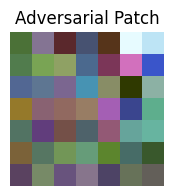

Attack Success Rate: 98.69%


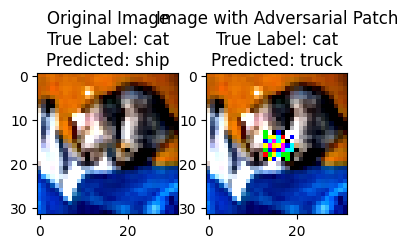

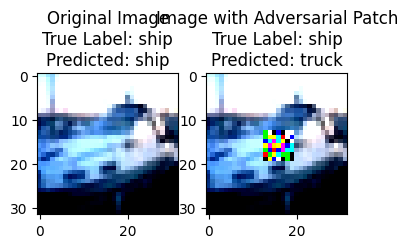

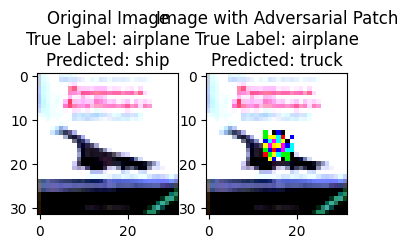

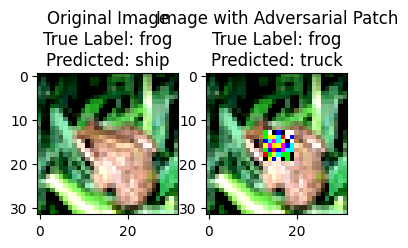

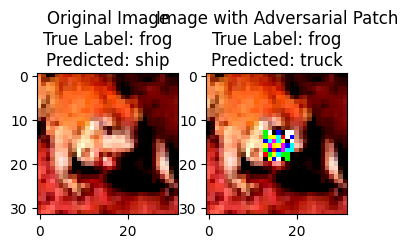


Training for patch size: (16, 16) with target class: truck
Epoch 1/20, Loss: 1.3239
Epoch 2/20, Loss: 0.5076
Epoch 3/20, Loss: 0.2991
Epoch 4/20, Loss: 0.1817
Epoch 5/20, Loss: 0.1204
Epoch 6/20, Loss: 0.0837
Epoch 7/20, Loss: 0.0613
Epoch 8/20, Loss: 0.0484
Epoch 9/20, Loss: 0.0399
Epoch 10/20, Loss: 0.0336
Epoch 11/20, Loss: 0.0293
Epoch 12/20, Loss: 0.0259
Epoch 13/20, Loss: 0.0231
Epoch 14/20, Loss: 0.0207
Epoch 15/20, Loss: 0.0187
Epoch 16/20, Loss: 0.0171
Epoch 17/20, Loss: 0.0157
Epoch 18/20, Loss: 0.0145
Epoch 19/20, Loss: 0.0135
Epoch 20/20, Loss: 0.0127
Visualizing patch of size (16, 16) for target class truck


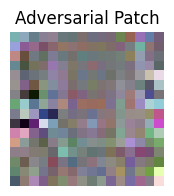

Attack Success Rate: 100.00%


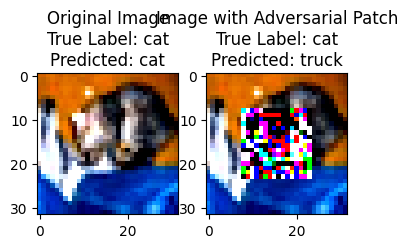

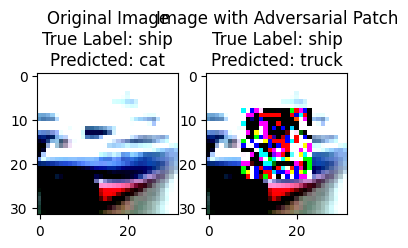

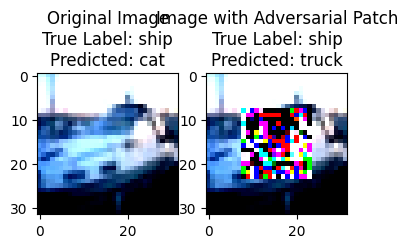

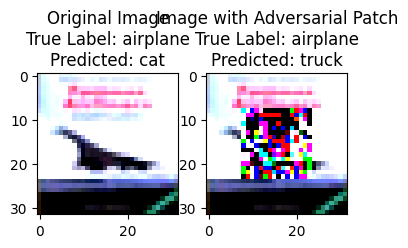

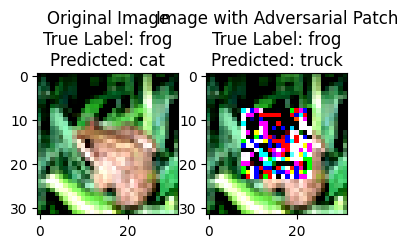

In [15]:

# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Targeted classes (plane, car, bird)
target_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Different patch sizes
patch_sizes = [(3, 3), (5, 5), (7, 7), (16, 16)]

# Train and evaluate patches for each target class
for target_class in target_classes:
    for patch_size in patch_sizes:
        print(f"\nTraining for patch size: {patch_size} with target class: {classes[target_class]}")
        patch = create_patch(patch_size)
        train_adversarial_patch(model, patch, target_class=target_class, num_epochs=20)

        # Save the patch
        torch.save(patch, f'adversarial_patch_{patch_size[0]}x{patch_size[1]}_target_{target_class}.pth')

        # Visualize the patch
        print(f"Visualizing patch of size {patch_size} for target class {classes[target_class]}")
        visualize_patch(patch)

        # Evaluate attack success rate
        evaluate_patch(model, patch, test_loader, target_class=target_class)

        # Visualize misclassified examples with the adversarial patch
        visualize_misclassified_patched_images(model, patch, test_loader, classes, target_class, num_examples=5)